# CNNs for Image Classification usage with Tensorboard:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
% load_ext tensorboard

In [6]:
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
import tensorflow as tf
import datetime

In [7]:
from tensorflow.keras.datasets import mnist  # Grayscale Image set
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# Clear any logs from previous runs
!rm -rf./logs/

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [10]:
x_train.shape

(60000, 28, 28)

In [11]:
single_img = x_train[0]
single_img.shape

(28, 28)

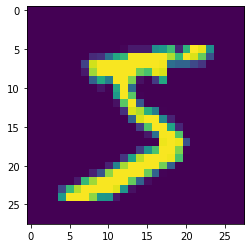

In [14]:
plt.imshow(single_img)

# PreProcessing Data
We first need to make sure the labels will be understandable by our CNN.

In [16]:
print(y_train)
print(y_test)

[5 0 4 ... 5 6 8]
[7 2 1 ... 4 5 6]


Hmmm, looks like our labels are literally categories of numbers. We need to translate this to be "one hot encoded" so our CNN can understand, otherwise it will think this is some sort of regression problem on a continuous axis. Luckily , Keras has an easy to use function for this:

In [17]:
from tensorflow.keras.utils import to_categorical

In [18]:
y_example = to_categorical(y_train)

In [20]:
y_example.shape

(60000, 10)

In [21]:
y_cat_test = to_categorical(y_test, 10)
y_cat_train = to_categorical(y_train, 10)

# Normalizing the data:

In [22]:
x_train = x_train / 255
x_test = x_test / 255

# Reshaping the Data

Right now our data is 60,000 images stored in 28 by 28 pixel array formation. 

This is correct for a CNN, but we need to add one more dimension to show we're dealing with 1 RGB channel (since technically the images are in black and white, only showing values from 0-255 on a single channel), an color image would have 3 dimensions.

In [23]:
x_train.shape

(60000, 28, 28)

In [24]:
x_train = x_train.reshape(60000, 28, 28, 1)

In [25]:
x_test = x_test.reshape(10000, 28, 28, 1)

# Training the model:

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

In [27]:
model = Sequential()

# CONVOLUTIONAL LAYER
model.add(Conv2D(filters=32, kernel_size=(4, 4), input_shape=(28, 28, 1), activation='relu', ))
# POOLING LAYER
model.add(MaxPool2D(pool_size=(2, 2)))

# FLATTEN IMAGES FROM 28 by 28 to 764 BEFORE FINAL LAYER
model.add(Flatten())

# 128 NEURONS IN DENSE HIDDEN LAYER (YOU CAN CHANGE THIS NUMBER OF NEURONS)
model.add(Dense(128, activation='relu'))

# LAST LAYER IS THE CLASSIFIER, THUS 10 POSSIBLE CLASSES
model.add(Dense(10, activation='softmax'))

# https://keras.io/metrics/
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])  # we can add in additional metrics https://keras.io/metrics/

In [28]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [29]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [30]:
model.fit(x_train, y_cat_train, epochs=10, validation_data=(x_test, y_cat_test),
          callbacks=[early_stop, tensorboard_callback])

Epoch 1/10
1875/1875 [==============================] - 39s 20ms/step - loss: 0.1367 - accuracy: 0.9592 - val_loss: 0.0526 - val_accuracy: 0.9829
Epoch 2/10
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0480 - accuracy: 0.9846 - val_loss: 0.0429 - val_accuracy: 0.9852
Epoch 3/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0290 - accuracy: 0.9907 - val_loss: 0.0356 - val_accuracy: 0.9886
Epoch 4/10
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0198 - accuracy: 0.9936 - val_loss: 0.0472 - val_accuracy: 0.9851
Epoch 5/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0146 - accuracy: 0.9952 - val_loss: 0.0475 - val_accuracy: 0.9859


In [31]:
losses = pd.DataFrame(model.history.history)

In [33]:
losses.head()

,loss,accuracy,val_loss,val_accuracy
0,0.136693,0.959250,0.052626,0.9829
1,0.048035,0.984617,0.042905,0.9852
2,0.029037,0.990733,0.035646,0.9886
3,0.019810,0.993550,0.047210,0.9851
4,0.014610,0.995233,0.047537,0.9859


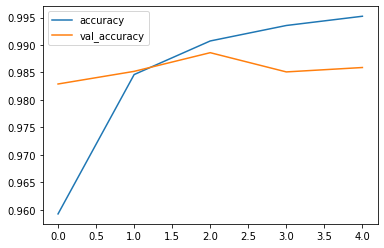

In [34]:
losses[['accuracy', 'val_accuracy']].plot()

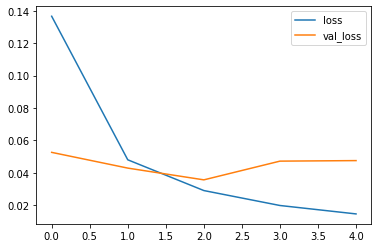

In [35]:
losses[['loss', 'val_loss']].plot()

# Predicting a given image:

In [37]:
my_number = x_test[0]

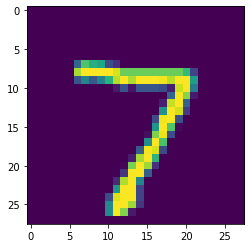

In [38]:
plt.imshow(my_number.reshape(28, 28))

In [42]:
# SHAPE --> (num_images,width,height,color_channels)
predictions = model(x_train[:1]).numpy()
tf.nn.softmax(predictions).numpy()

array([[0.08591461, 0.08591461, 0.08591461, 0.09017374, 0.08591461,
        0.2225094 , 0.08591461, 0.08591461, 0.08591463, 0.08591462]],
      dtype=float32)

In [44]:
print(model.evaluate(x_test, y_cat_test, verbose=1))

313/313 [==============================] - 3s 8ms/step - loss: 0.0475 - accuracy: 0.9859
[0.04753734916448593, 0.9858999848365784]
